- CNN pour la clacification du dataset avec les 10 catégorie https://keras.io/api/datasets/cifar10/
- Model inspiration : [link](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- Fine tuning de mobilenet (ajout d'un dense layer pour catégorisation)

## Step 0: Mac M2 GPU

- The Neural Engine is primarily used for inference through Core ML
- TensorFlow training uses the GPU cores via Metal Performance Shaders (MPS)
- As of 2024, use Python 3.11 with TensorFlow 2.15.1 and tensorflow-metal 1.1.0 for best compatibility

In [1]:
%pip install tensorflow-metal
%pip install tensorflow-macos

# Step 1: System Information and TensorFlow Configuration
import sys
import platform
import subprocess
import tensorflow as tf

print("="*80)
print(" "*25 + "SYSTEM INFORMATION")
print("="*80)

# System details
print(f"\n📱 Platform: {platform.platform()}")
print(f"🏗️ Architecture: {platform.machine()}")
print(f"🐍 Python Version: {sys.version}")
print(f"📦 TensorFlow Version: {tf.__version__}")

# Check for tensorflow-metal
try:
    import tensorflow_metal
    print(f"TensorFlow Metal: Installed")
except ImportError:
    print("TensorFlow Metal: Not installed - GPU acceleration unavailable!")
    print("   Install with: pip install tensorflow-metal")

# Check macOS version
try:
    macos_version = subprocess.check_output(['sw_vers', '-productVersion']).decode().strip()
    print(f"macOS Version: {macos_version}")
    
    # Verify minimum version (12.0 required for Metal)
    major, minor = map(int, macos_version.split('.')[:2])
    if major < 12:
        print("WARNING: macOS 12.0+ required for Metal GPU support!")
except:
    pass

print("\n" + "="*80)
print(" "*25 + "GPU DETECTION & VERIFICATION")
print("="*80)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
                         SYSTEM INFORMATION

📱 Platform: macOS-15.6.1-arm64-arm-64bit
🏗️ Architecture: arm64
🐍 Python Version: 3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
📦 TensorFlow Version: 2.16.2
TensorFlow Metal: Not installed - GPU acceleration unavailable!
   Install with: pip install tensorflow-metal
macOS Version: 15.6.1

                         GPU DETECTION & VERIFICATION


In [2]:
# Step 2: GPU Detection and Configuration
print("\n Detecting available devices...")

# List all physical devices
devices = tf.config.list_physical_devices()
print(f"\nAll devices found: {len(devices)}")
for device in devices:
    print(f"   - {device}")

# Check specifically for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU DETECTED! Found {len(gpus)} GPU device(s)")
    for i, gpu in enumerate(gpus):
        print(f"\nGPU {i} Details:")
        print(f"   Device: {gpu}")
        try:
            details = tf.config.experimental.get_device_details(gpu)
            for key, value in details.items():
                print(f"   {key}: {value}")
        except:
            print(" (Unable to get detailed GPU information)")
    
    # Configure GPU memory growth
    print("\n Configuring GPU memory growth...")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" Memory growth enabled - GPU will allocate memory as needed")
    except RuntimeError as e:
        print(f" Could not set memory growth: {e}")
        
else:
    print("\n NO GPU DETECTED!")
    print("   Possible reasons:")
    print("   1. tensorflow-metal not installed")
    print("   2. Incompatible TensorFlow version")
    print("   3. System doesn't have compatible GPU")
    print("\n   To install tensorflow-metal:")
    print("   pip install tensorflow-metal==1.1.0")

# Enable device placement logging
print("\n📍 Enabling device placement logging...")
tf.debugging.set_log_device_placement(False)


 Detecting available devices...

All devices found: 2
   - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
   - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

GPU DETECTED! Found 1 GPU device(s)

GPU 0 Details:
   Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
   device_name: METAL

 Configuring GPU memory growth...
 Memory growth enabled - GPU will allocate memory as needed

📍 Enabling device placement logging...


# Step 1: Initialisation

In [3]:
# MINIMAL REQUIREMENTS 

# Python 
import sys
assert sys.version_info >= (3,11)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# COLAB DETECTION 

try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TENSORFLOW
import tensorflow as tf
assert tf.__version__ >= "2.16"


# COMMON IMPORTS
import numpy as np
import os
from datetime import datetime


# REPRODUCTIBILITY
np.random.seed(42)
tf.random.set_seed(42)

# MATPLOTLIB CONFIGURATION
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




# Step 2: load the data

In [4]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = cifar10.load_data()


# Step : Data preparation

In [5]:
# Create the validation set from the train set
# Take 20% (0.2) of the total set (50000 * 0.2 = 10000 record)
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# One hot encode target values
y_train_new = tf.keras.utils.to_categorical(y_train_new, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

# Format in float32 and normalize to [0,1]
X_train_new = X_train_new.astype('float32') / 255.0
X_val       = X_val.astype('float32') / 255.0
X_test      = X_test.astype('float32') / 255.0

# Define class name
classNames = ['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']




# Step : Display data and stuff

(40000, 10)
(10000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


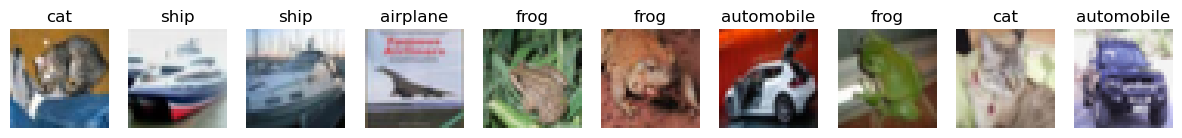

In [6]:
print(y_train_new.shape)
print(y_val.shape)
print(y_test.shape)

print(y_train_new[0])
print(y_val[0])
print(y_test[0])

fig, ax = plt.subplots(1, 10, figsize=(15,2))
for i in range(10):
    ax[i].axis('off')
    cls_idx = np.argmax(y_test[i])
    ax[i].set_title(classNames[cls_idx])
    ax[i].imshow(X_test[i])
plt.show()

# Step : Define models

In [7]:
'''
    small : Start simple
    - Layer 1 : 2 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 2 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    medium : Add 1 layer with Conv 128
    - Layer 1 : 2 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 2 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 2 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    large : Add 1 Conv in each layer
    - Layer 1 : 3 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 3 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 3 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    large-wide : Double filters on each layer + adapte dense layer to match
    - Layer 1 : 3 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 3 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 3 x (Conv 256 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 256 + BatchNorm + Dropout(0.5) + Dense soft max

'''

def create_model(model_name="small"):
    if model_name == "small":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "medium":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "large":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "large_wide":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model


# Step : Define optimizers

In [8]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


2025-09-14 23:13:36.570303: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-09-14 23:13:36.570341: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-09-14 23:13:36.570374: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-09-14 23:13:36.570437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-14 23:13:36.570458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Step : Compile and display the model

In [9]:

model = create_model("small") 
model.compile(loss="categorical_crossentropy",
              optimizer=opt, 
              metrics=['accuracy'])
# Show model shape
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,554 (2.26 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

# Step : Preprocess for training

In [10]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


# Step : Train the small model

In [11]:
history_small = model.fit(train_ds, epochs=25, validation_data=val_ds)

Epoch 1/25


2025-09-14 23:13:37.830103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.4600 - loss: 1.5828 - val_accuracy: 0.6107 - val_loss: 1.0871
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.6214 - loss: 1.0697 - val_accuracy: 0.6796 - val_loss: 0.9104
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6807 - loss: 0.9049 - val_accuracy: 0.7216 - val_loss: 0.8025
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7168 - loss: 0.8154 - val_accuracy: 0.7140 - val_loss: 0.8186
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7409 - loss: 0.7493 - val_accuracy: 0.7467 - val_loss: 0.7323
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7573 - loss: 0.6983 - val_accuracy: 0.7612 - val_loss: 0.6874
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7731 - loss: 0.6547 - val_accuracy: 0.7626 - val_loss: 0.6905
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7835 - loss: 0.6184 - val_accurac

# Step : Define Plot function

In [12]:

def plot_result(history):
    # Create subplots for Accuracy and Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Val')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot Loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Val')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Step : Run plot results function

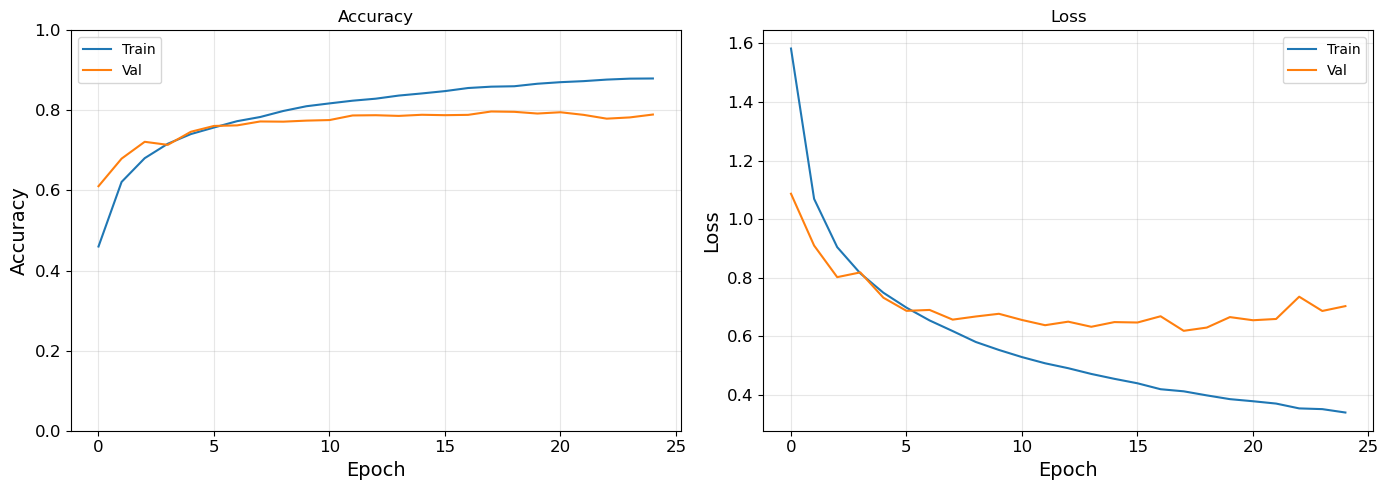

In [13]:
plot_result(history_small)

# Step : Define Evaluation function

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_and_report(model, X_test, y_test, class_names, batch_size=256):

    # Evaluate model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}\n")

    # Get predictions
    y_prob = model.predict(X_test, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    # Convert one-hot encoded y_test to class indices
    y_true = np.argmax(y_test, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Step : Run Evaluation function

Test Accuracy: 0.7873



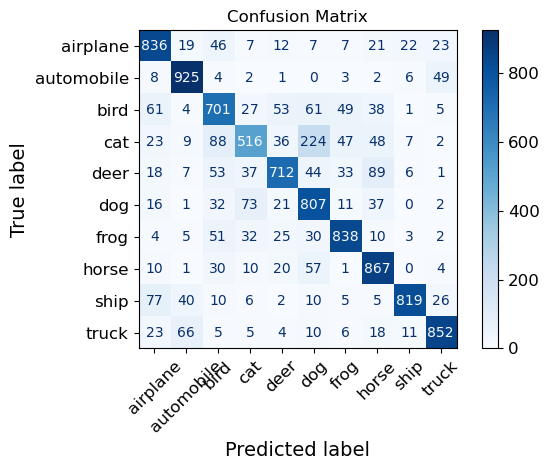

Classification Report:

              precision    recall  f1-score   support

    airplane       0.78      0.84      0.81      1000
  automobile       0.86      0.93      0.89      1000
        bird       0.69      0.70      0.69      1000
         cat       0.72      0.52      0.60      1000
        deer       0.80      0.71      0.76      1000
         dog       0.65      0.81      0.72      1000
        frog       0.84      0.84      0.84      1000
       horse       0.76      0.87      0.81      1000
        ship       0.94      0.82      0.87      1000
       truck       0.88      0.85      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [15]:
evaluate_and_report(model, X_test, y_test, class_names=classNames)

# Step : Same but medium model



In [16]:
# Get and train model "medium"
model_medium = create_model("medium") 
opt = tf.keras.optimizers.Adam()
model_medium.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics=['accuracy']
)

model_medium.summary()

history_medium = model_medium.fit(train_ds, epochs=50, validation_data=val_ds)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4347 - loss: 1.6900 - val_accuracy: 0.5430 - val_loss: 1.3239
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6109 - loss: 1.0973 - val_accuracy: 0.6673 - val_loss: 0.9458
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.6799 - loss: 0.9153 - val_accuracy: 0.7269 - val_loss: 0.7806
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.7217 - loss: 0.8011 - val_accuracy: 0.7218 - val_loss: 0.7967
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.7475 - loss: 0.7185 - val_accuracy: 0.7633 - val_loss: 0.6818
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.7751 - loss: 0.6513 - val_accuracy: 0.7938 - val_loss: 0.6187
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7946 - loss: 0.5942 - val_accuracy: 0.7969 - val_loss: 0.5921
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.8100 - loss: 0.5474 - 

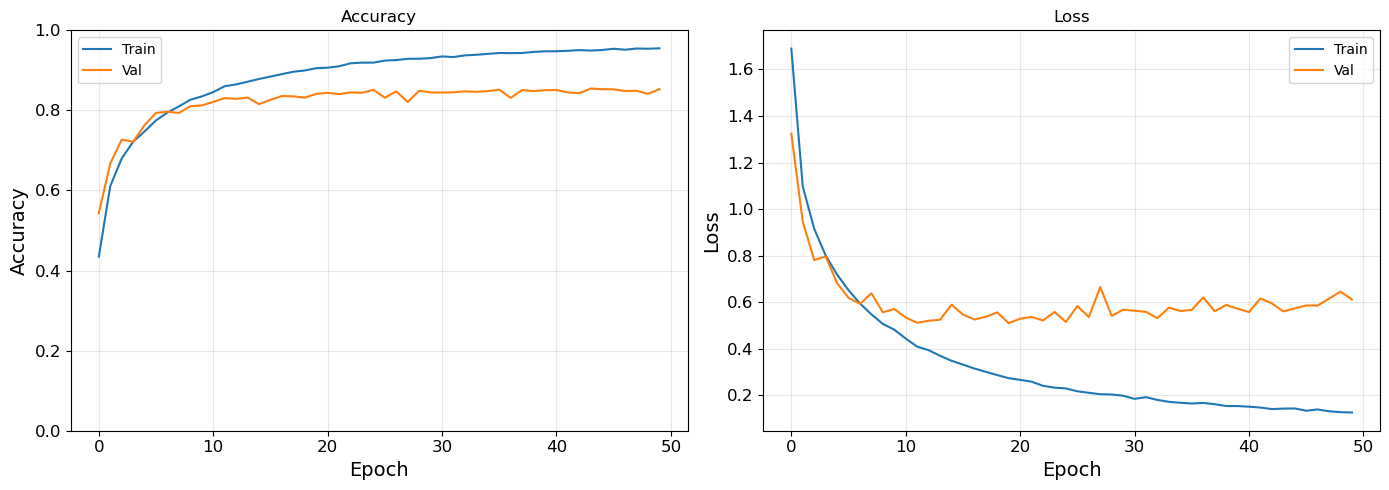

Test Accuracy: 0.8444



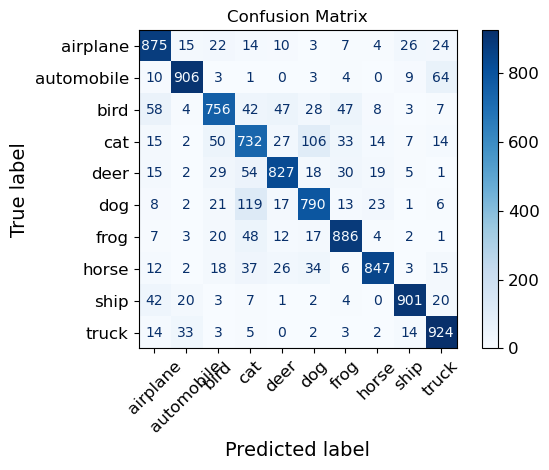

Classification Report:

              precision    recall  f1-score   support

    airplane       0.83      0.88      0.85      1000
  automobile       0.92      0.91      0.91      1000
        bird       0.82      0.76      0.79      1000
         cat       0.69      0.73      0.71      1000
        deer       0.86      0.83      0.84      1000
         dog       0.79      0.79      0.79      1000
        frog       0.86      0.89      0.87      1000
       horse       0.92      0.85      0.88      1000
        ship       0.93      0.90      0.91      1000
       truck       0.86      0.92      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



In [17]:
plot_result(history_medium)
evaluate_and_report(model_medium, X_test, y_test, class_names=classNames)

# Step : Same but large model

In [18]:
# Get and train model "large"
model_large = create_model("large") 
opt = tf.keras.optimizers.Adam()
model_large.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics=['accuracy']
)

model_large.summary()

history_large = model_large.fit(train_ds, epochs=50, validation_data=val_ds)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 128)      │       147,58

 Total params: 747,530 (2.85 MB)

 Trainable params: 745,930 (2.85 MB)

 Non-trainable params: 1,600 (6.25 KB)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 65ms/step - accuracy: 0.4120 - loss: 1.7491 - val_accuracy: 0.5823 - val_loss: 1.1901
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.5969 - loss: 1.1346 - val_accuracy: 0.6784 - val_loss: 0.9222
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.6818 - loss: 0.9159 - val_accuracy: 0.7255 - val_loss: 0.7838
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.7279 - loss: 0.7926 - val_accuracy: 0.7439 - val_loss: 0.7202
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.7563 - loss: 0.7027 - val_accuracy: 0.7280 - val_loss: 0.7919
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7866 - loss: 0.6227 - val_accuracy: 0.7811 - val_loss: 0.6266
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.8071 - loss: 0.5674 - val_accuracy: 0.7868 - val_loss: 0.6425
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.8225 - loss: 0.5198 - 

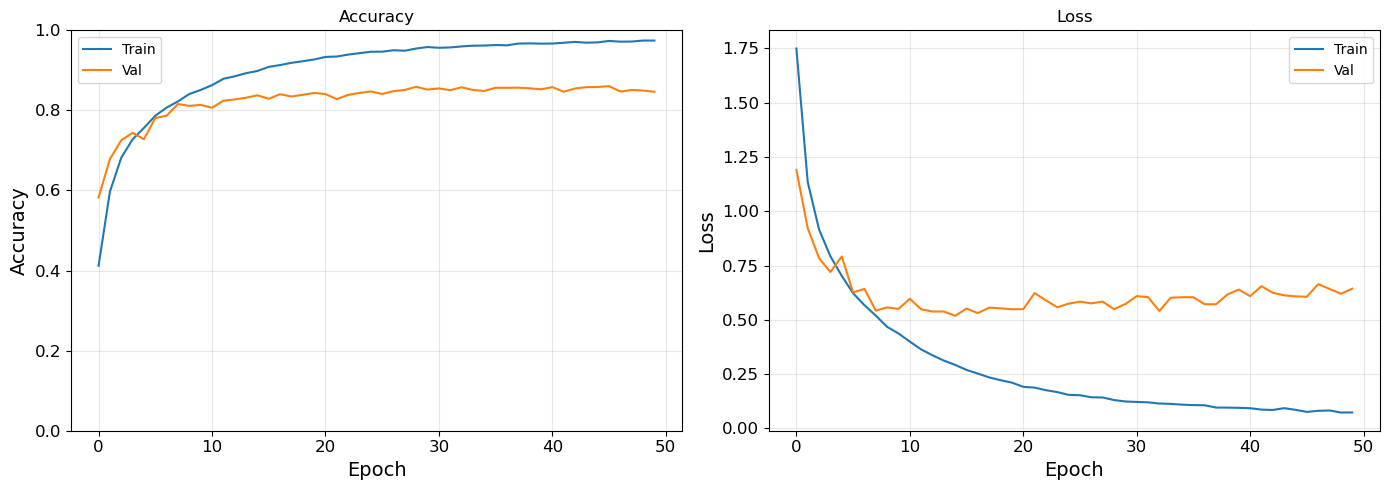

Test Accuracy: 0.8492



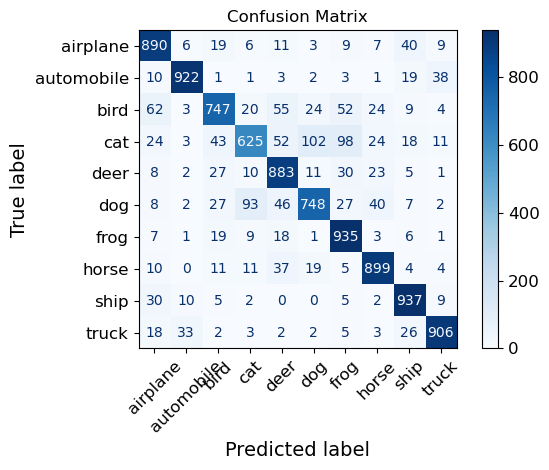

Classification Report:

              precision    recall  f1-score   support

    airplane       0.83      0.89      0.86      1000
  automobile       0.94      0.92      0.93      1000
        bird       0.83      0.75      0.79      1000
         cat       0.80      0.62      0.70      1000
        deer       0.80      0.88      0.84      1000
         dog       0.82      0.75      0.78      1000
        frog       0.80      0.94      0.86      1000
       horse       0.88      0.90      0.89      1000
        ship       0.87      0.94      0.90      1000
       truck       0.92      0.91      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [19]:
plot_result(history_large)
evaluate_and_report(model_large, X_test, y_test, class_names=classNames)

# Step : Same but with large-wide model

In [20]:
# Get and train model "large_wide"
model_large_wide = create_model("large_wide") 
opt = tf.keras.optimizers.Adam()
model_large_wide.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics=['accuracy']
)

model_large_wide.summary()

history_large_wide = model_large_wide.fit(train_ds, epochs=50, validation_data=val_ds)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 256)      │       590,08

 Total params: 2,977,802 (11.36 MB)

 Trainable params: 2,974,602 (11.35 MB)

 Non-trainable params: 3,200 (12.50 KB)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 71ms/step - accuracy: 0.4603 - loss: 1.6274 - val_accuracy: 0.6064 - val_loss: 1.1974
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.6565 - loss: 0.9777 - val_accuracy: 0.7316 - val_loss: 0.7605
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.7411 - loss: 0.7437 - val_accuracy: 0.7412 - val_loss: 0.7406
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.7872 - loss: 0.6188 - val_accuracy: 0.7804 - val_loss: 0.6381
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.8200 - loss: 0.5292 - val_accuracy: 0.7926 - val_loss: 0.6391
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8447 - loss: 0.4543 - val_accuracy: 0.8210 - val_loss: 0.5351
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.8669 - loss: 0.3869 - val_accuracy: 0.8241 - val_loss: 0.5313
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8833 - loss: 0.3390 - 

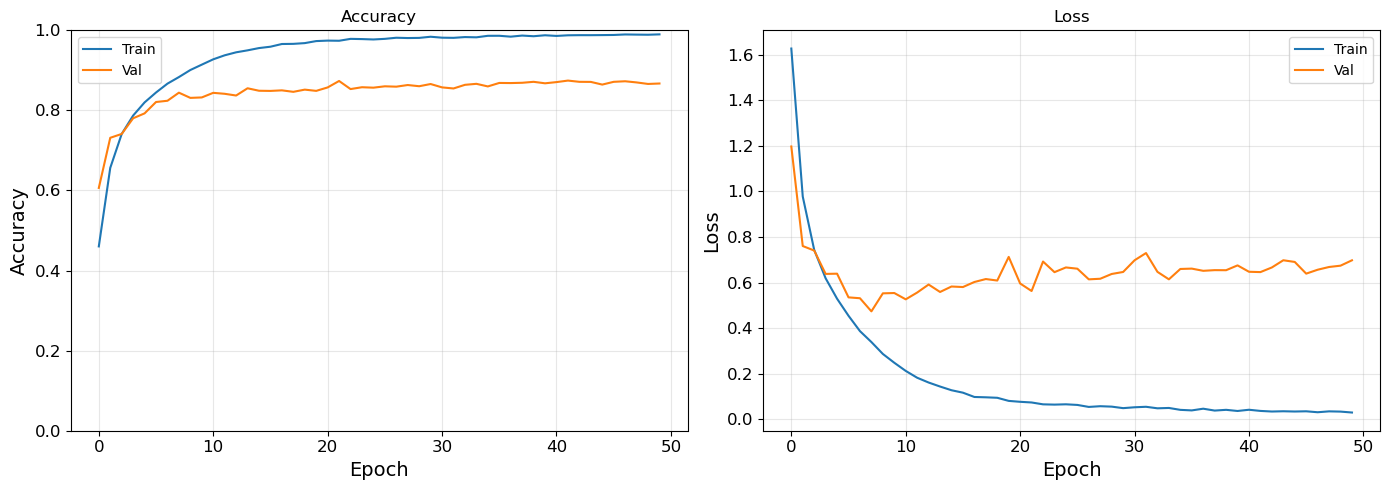

Test Accuracy: 0.8625



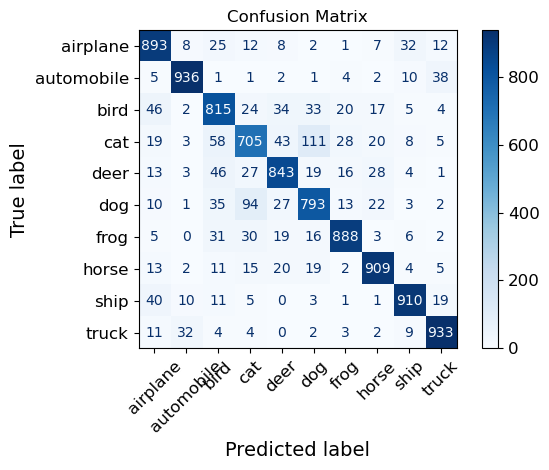

Classification Report:

              precision    recall  f1-score   support

    airplane       0.85      0.89      0.87      1000
  automobile       0.94      0.94      0.94      1000
        bird       0.79      0.81      0.80      1000
         cat       0.77      0.70      0.74      1000
        deer       0.85      0.84      0.84      1000
         dog       0.79      0.79      0.79      1000
        frog       0.91      0.89      0.90      1000
       horse       0.90      0.91      0.90      1000
        ship       0.92      0.91      0.91      1000
       truck       0.91      0.93      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [21]:
plot_result(history_large_wide)
evaluate_and_report(model_large_wide, X_test, y_test, class_names=classNames)

# Step : Add callback function

In [22]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-9
)


# Step : Large_wide with callback

In [23]:
# Get and train model "large_wide"
model_LW_ADAM_CB = create_model("large_wide") 
opt = tf.keras.optimizers.Adam()
model_LW_ADAM_CB.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics=['accuracy']
)

model_LW_ADAM_CB.summary()

history_LW_ADAM_CB = model_LW_ADAM_CB.fit(
                        train_ds, 
                        epochs=100, 
                        callbacks = [lr_scheduler],
                        verbose=1,
                        validation_data=val_ds
                        )

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 8, 8, 256)      │       590,08

 Total params: 2,977,802 (11.36 MB)

 Trainable params: 2,974,602 (11.35 MB)

 Non-trainable params: 3,200 (12.50 KB)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 110ms/step - accuracy: 0.4642 - loss: 1.6048 - val_accuracy: 0.6025 - val_loss: 1.2392 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.6647 - loss: 0.9641 - val_accuracy: 0.7323 - val_loss: 0.7757 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 101ms/step - accuracy: 0.7402 - loss: 0.7479 - val_accuracy: 0.7564 - val_loss: 0.7148 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.7821 - loss: 0.6311 - val_accuracy: 0.7967 - val_loss: 0.5941 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 97ms/step - accuracy: 0.8161 - loss: 0.5316 - val_accuracy: 0.8037 - val_loss: 0.5798 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.8419 - loss: 0.4556 - val_accuracy: 0.8170 - val_loss: 0.5308 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0

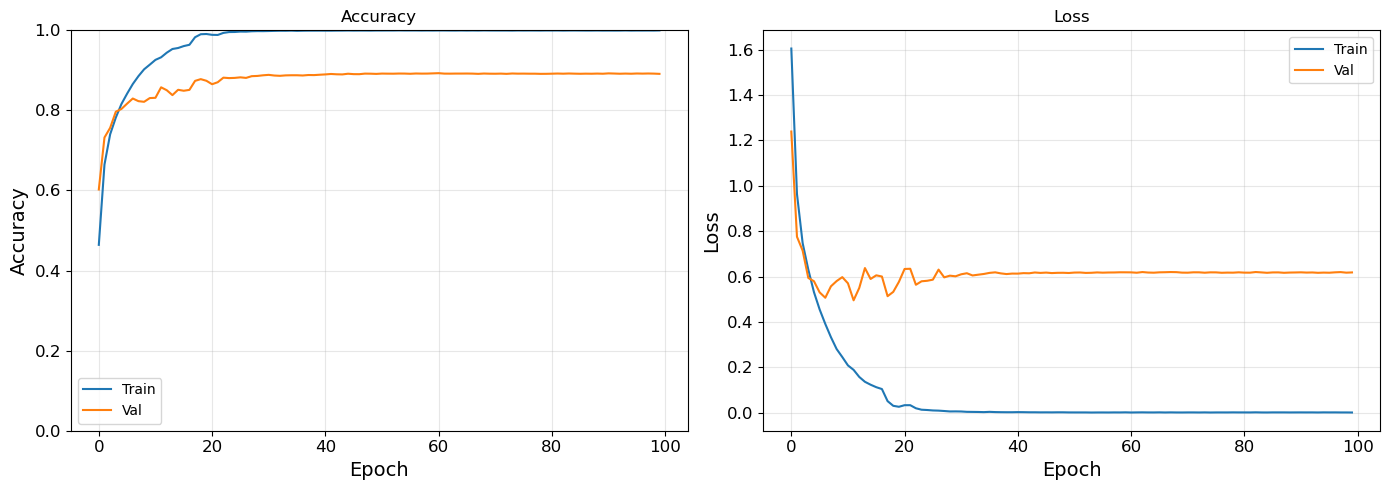

Test Accuracy: 0.8874



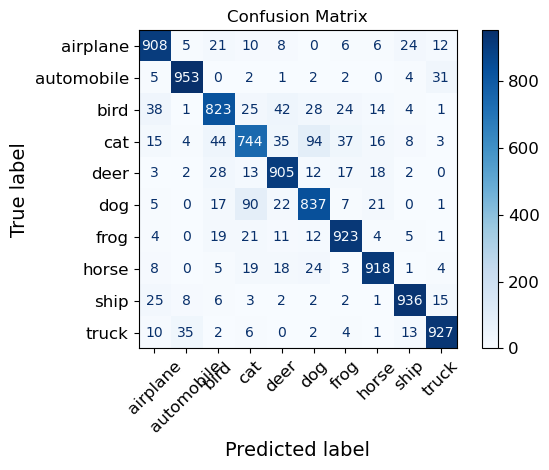

Classification Report:

              precision    recall  f1-score   support

    airplane       0.89      0.91      0.90      1000
  automobile       0.95      0.95      0.95      1000
        bird       0.85      0.82      0.84      1000
         cat       0.80      0.74      0.77      1000
        deer       0.87      0.91      0.89      1000
         dog       0.83      0.84      0.83      1000
        frog       0.90      0.92      0.91      1000
       horse       0.92      0.92      0.92      1000
        ship       0.94      0.94      0.94      1000
       truck       0.93      0.93      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [24]:
plot_result(history_LW_ADAM_CB)
evaluate_and_report(model_LW_ADAM_CB, X_test, y_test, class_names=classNames)

# Step : Add simple data augmentation

In [25]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Step : Update Preprocess for training


In [26]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .map(lambda x, y: (augment(x, training=True), y),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


# Step : Train with data augmentation

In [27]:
# Get and train model "large_wide"
model_LW_ADAM_CB_AUG = create_model("large_wide") 
opt = tf.keras.optimizers.Adam()
model_LW_ADAM_CB_AUG.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics=['accuracy']
)

model_LW_ADAM_CB_AUG.summary()

history_LW_ADAM_CB_AUG = model_LW_ADAM_CB_AUG.fit(
                        train_ds, 
                        epochs=100, 
                        callbacks = [lr_scheduler],
                        verbose=1,
                        validation_data=val_ds
                        )

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 8, 8, 256)      │       590,08

 Total params: 2,977,802 (11.36 MB)

 Trainable params: 2,974,602 (11.35 MB)

 Non-trainable params: 3,200 (12.50 KB)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 107ms/step - accuracy: 0.4166 - loss: 1.7677 - val_accuracy: 0.5076 - val_loss: 1.4850 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.5960 - loss: 1.1609 - val_accuracy: 0.6358 - val_loss: 1.1639 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.6895 - loss: 0.8819 - val_accuracy: 0.6959 - val_loss: 0.8900 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 121ms/step - accuracy: 0.7380 - loss: 0.7569 - val_accuracy: 0.7788 - val_loss: 0.6524 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7727 - loss: 0.6683
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - accuracy: 0.7756 - loss: 0.6614 - val_accuracy: 0.7505 - val_loss: 0.7750 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - accuracy: 0

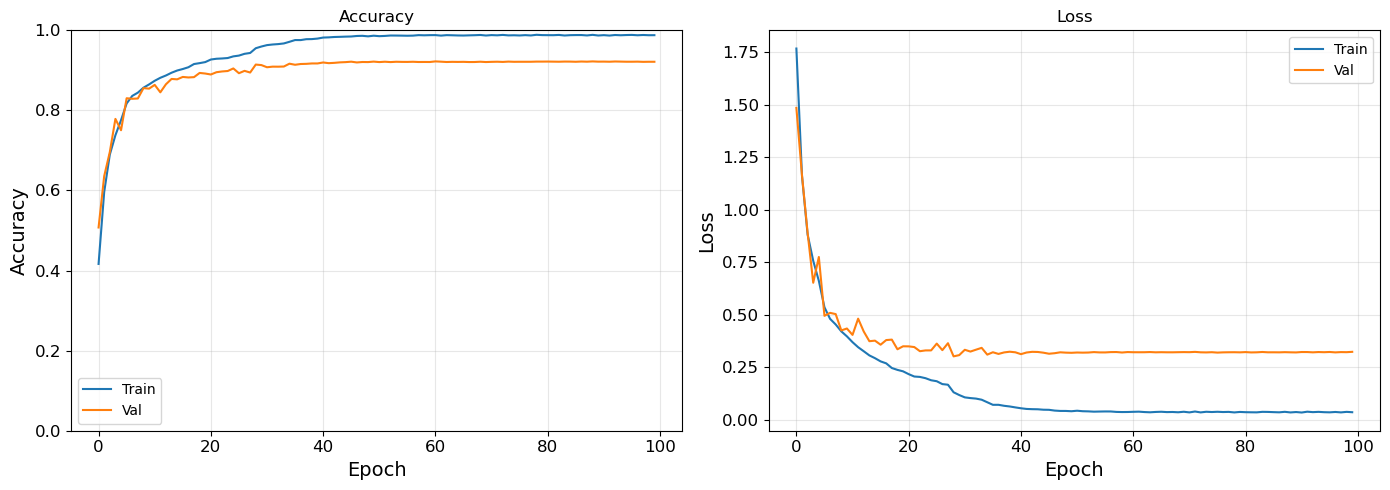

Test Accuracy: 0.9133



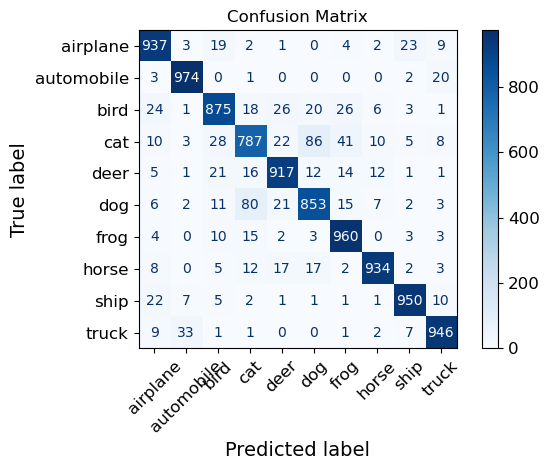

Classification Report:

              precision    recall  f1-score   support

    airplane       0.91      0.94      0.92      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.90      0.88      0.89      1000
         cat       0.84      0.79      0.81      1000
        deer       0.91      0.92      0.91      1000
         dog       0.86      0.85      0.86      1000
        frog       0.90      0.96      0.93      1000
       horse       0.96      0.93      0.95      1000
        ship       0.95      0.95      0.95      1000
       truck       0.94      0.95      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [28]:
plot_result(history_LW_ADAM_CB_AUG)
evaluate_and_report(model_LW_ADAM_CB_AUG, X_test, y_test, class_names=classNames)